# Kolorizacija slika korišćenjem uslovnih generativnih suparničkih mreža

Kolorizacija crno belih slika predstavlja jednu od mnogih primena dubokog učenja. Godinama je kolorizacija predstavlja težak problem, koji je zahtevao dosta ljudskog angažovanja, dok se sada problem u potpunosti automatizuje korišćenjem Veštačke inteligencije i dubokog učenja.

Kako rešenje ovog problema ima brojne primene, kao što su restauracija slika i kolorizacija starih fotografija, postoji veliki broj pristupa njegovog rešenja, od čega je korišćenje konvolutivnih neuronskih mreža i generativnih suparničkih mreža najčešće.

U okviru ovog projekta je implementiran pristup korišćenja uslovne generativne suparničke mreže, koja je predložena u radu [Image-to-Image Translation with Conditional Adversarial Nets](https://arxiv.org/abs/1611.07004). 
Model je delom izmenjen zbog hardverskih ograničenja. Takođe, delovi koda koji su preuzeti su označeni i navedena je literatura.

Sadržaj sveske:
1.   Imports
2.   Skup podataka
3.   Model
4.   Evaluacija
5.   Rezultati

## Imports

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import PIL
from IPython.display import clear_output
from tqdm.notebook import tqdm
import os

## Skup podataka

Skup podataka korišćen za treniranje modela je preuzet sa [Kaggle](https://www.kaggle.com/) platforme i sastoji se od ??? [slika umetničkih dela](https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving). Tačnije korišćen je njegov podskup slika na platnu, dok su crteži, skulpture i gravure izbačeni zbog nerelevantnosti za dati problem.


In [42]:
use_collab = False
if use_collab:
    # Zbog rada u Google Colabu, 
    #
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
  
    path_target = "/content/drive/MyDrive/dataset/target_val/"
    path_train = "/content/drive/MyDrive/dataset/train/"
    checkpoint_folder = "/content/drive/MyDrive/checkpoints/"
else:
    path_target = "data/target/"
    path_train = "data/train/"
    checkpoint_folder = "checkpoints/"

In [43]:
image_names = os.listdir(path_target)[1:]

In [44]:
num_of_images = len(image_names)

In [45]:
image_names[:5]

['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg']

### Formiranje trening skupa
Kako se u skupu podataka nalaze već obojene slike, potrebno je da od njih napravimo crno-bele slike, što se jednostavno može postići uvođenjem novog sistema prikaza boja.
#### RGB vs LAB
Prilikom učitavanja slika u boji dobijamo 3d vektor sa informacijama o visini, širini i boji. Na poslednjoj osi se nalazi informacija o boji. Ukoliko se za prikaz boje koristi RGB sistem, za svaki piksel se čuvaju 3 informacije koje sadrže informacije o zastupljenosti crvene, zelene i plave boje redom.

<img src='content/rgb.png'>


U L*a*b sistemu prikaza boje, takođe se čuvaju tri broja za svaki piksel, ali oni sada imaju drugačije značenje. Prvi broj (kanal) L, sadrži informaciju o osvetljenosti. Prilikom vizuelizacije ovog kanal možemo zaključiti da on upravo predstavlja crno belu verziju početne slike. Kanali a i b redom enkodiraju zastupljenost zeleno-crvene i žuto-plave. 
<img src='content/lab.png'>


*Slike preuzete sa sledećeg [linka](https://fairyonice.github.io/Color-space-defenitions-in-python-RGB-and-LAB.html) i ne nalazi se u skupu podataka na kome je treniran model*

Dakle, da bismo iz slike u boji dobili crno-belu sliku, potrebno je samo da je konvertujemo iz RGB moda u Lab mod. To činimo uz pomoć [Pillow biblioteke.](https://pillow.readthedocs.io/en/stable/)
Još jedna bitna napomena, kada izvršimo konverziju kao u kodu ispod, izvlačimo samo informaciju o L kanalu. Da bi nam slike za trening idalje imale tri kanala, kao i da bismo mogli da ih poredimo sa slikama u boji(koje su u RGB modu), i računamo grešku, vršimo ponovnu konverziju u RGB.

In [46]:
def deColorization(path):
    for image in tqdm(path):
        #try:
        img = PIL.Image.open(path_target + image)
        img = img.convert('L')
        img = img.convert('RGB')
        img.save(path_train + image)
        #except:
            # Pošto su u originalnom skupu postojale nevalidne slike, koje su izbacivale grešku prilikom pozivanja open
            # Ukoliko je greška, briše se iz skupa podataka 
            
            #os.remove(path_target + image)
        #    pass
deColorization(image_names)

  0%|          | 0/2042 [00:00<?, ?it/s]

### Podela na trening i validacioni skup


In [47]:
size_of_imgs = len(image_names)
train_percentage = 0.8
train_urls = image_names[:int(train_percentage*size_of_imgs)]
val_urls = image_names[int(train_percentage*size_of_imgs)+1:]

In [48]:
size_of_imgs # veličina skupa podataka

2042

In [49]:
train_urls[:25]

['0001.jpg',
 '0002.jpg',
 '0003.jpg',
 '0004.jpg',
 '0005.jpg',
 '0007.jpg',
 '0008.jpg',
 '0010.jpg',
 '0011.jpg',
 '0013.jpg',
 '0014.jpg',
 '0015.jpg',
 '0016.jpg',
 '0018.jpg',
 '0019.jpg',
 '0020.jpg',
 '0021.jpg',
 '0022.jpg',
 '0023.jpg',
 '0024.jpg',
 '0026.jpg',
 '0027.jpg',
 '0028.jpg',
 '0029.jpg',
 '0030.jpg']

### Uzorak slika iz skupa podataka

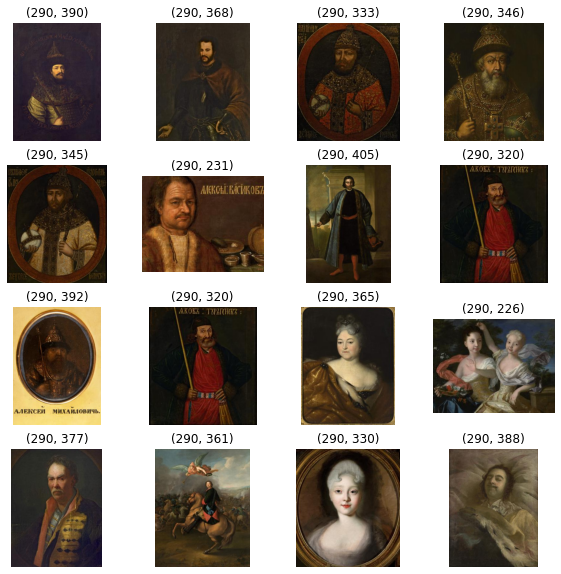

In [50]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), image_names):
    try:
        img = PIL.Image.open(path_target + img_path)
        ax.imshow(img)
        ax.set_title(img.size)
        ax.axis("off")
    except:
        pass

### Preprocesiranje slika
Ono što možemo primetiti iz prethodne diskusije jeste, da naši podaci ne mogu odmah da se iskoriste za treniranje modela iz sledećih razloga:


1.   Kao što vidimo na uzorku skupa podataka, slike nisu uniformne veličine
2.   Prilikom rada sa neuronskim mrežama uvek se preporučuje normalizacija podataka

Takođe, sa obzirom na to da radimo sa relativno malim skupom podataka,primenićemo i neke od tehnika augmentacija skupa podataka za trening, slučajnom rotacijom u levo ili desno.



In [11]:
## Preprocesiranje
#sve slike želimo da skaliramo na (256, 256, 3)
img_size = 256 

@tf.function
# Skaliranje
def resize(input_img, tar_img, img_size):
    input_img = tf.image.resize(input_img, [img_size, img_size])
    tar_img = tf.image.resize(tar_img, [img_size, img_size])
    
    return input_img, tar_img

#Normalizacija
# Vrednosti u svakom kanalu su u intervalu [0, 255]
# Skaliramo ih na interval [-1, 1]

def normalize(input_img, tar_img):
    input_img = (input_img/255.) - 1
    tar_img = (tar_img/255.) - 1
    return input_img, tar_img

# Augemntacija podataka
def augmentation(input_img, tar_img):
    input_img, tar_img = resize(input_img, tar_img, 572)

    stacked_image = tf.stack([input_img, tar_img], axis=0)
    
    cropped_image = tf.image.random_crop(stacked_image, size=[2, img_size, img_size, 3])
    
    input_img, tar_img = cropped_image[0], cropped_image[1]
    if tf.random.uniform(()) > 0.5:
        input_img = tf.image.flip_left_right(input_img)
        tar_img = tf.image.flip_left_right(tar_img)
    return input_img, tar_img

### Učitavanje podataka i preprocesiranje


In [12]:
def load_image(filename, augment=True):
    input_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(path_train + filename)), tf.float32)[..., :3]
    tar_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(path_target + filename)), tf.float32)[..., :3]
    input_img, tar_img = resize(input_img, tar_img, img_size)
    if augment:
        input_img, tar_img = augmentation(input_img, tar_img)
  
    input_img, tar_img = normalize(input_img, tar_img)
    return input_img, tar_img


def load_train_image(filename):
    return load_image(filename)

def load_val_image(filename):
    return load_image(filename, False) # Nad validacionim skupom ne vrsimo augmentaciju

Primer instance iz skupa za podataka nakon preprocesiranja.

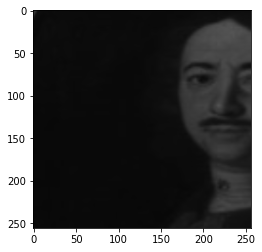

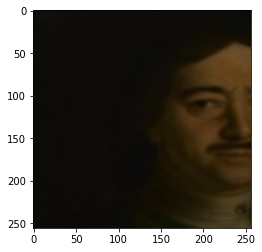

In [13]:
plt.figure()
plt.imshow(((load_train_image(val_urls[0])[0]) + 1. ) / 2.); # pre prikazivanja vraćamo u vrednosti iz intervala [-1, 1] u interval [0, 1]
plt.figure()
plt.imshow(((load_train_image(val_urls[0])[1]) + 1. ) / 2.); 

U okviru rada je naznačeno da se kod problema generisanja dobijaju bolji rezultati prilikom korišćenja *batchova* veličine 1.

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

val_dataset = tf.data.Dataset.from_tensor_slices(val_urls)
val_dataset = val_dataset.map(load_val_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(1)

## MODEL

U narednoj sekciji će detaljno biti opisan model uslovnih generativnih suparničkih mreža kao i implementacija.
Neformalno, GAN se sastoji od dva modela - generatora i discriminatora, koji zajedno rešavaju problem. U našem slučaju, generator generiše "lažne" slike u boji, dok diskriminator ima zadatak da razlikuje lažne od originalnih slika. 

Postavlja se i pitanje na osnovu čega model sadrži "uslovne" u svom imenu. U našem slučaju, uslov je crno-bela slika koja se prosleđuje i generatoru i diskriminatoru.
<img src='content/cGan.png'>

### Generator - konvolutivna U-net

Za arhitekturu generatora je predložen konvolutivni u-net.
U-net funkcioniše na sličan način kao model encoder-decoder, sa dodatim skip konekcijama, koje povezuju svaki  _i-ti_ sloj encodera sa _n-i-im_ slojem dekodera, gde je _n_ ukupan broj slojeva u mreži.

U-net je postiže bolje rezultate u odnosu na encoder-decoder modele, nevezano za uslovne GAN-ove i iz tog razloga je implementirana u ovom projektu.

<img src="content/u-net-architecture.png">

_slika preuzeta sa [linka.](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)_

##### Arhitektura U-neta
CD512-CD512-CD512-C512-C256-C128-C64 u okviru enkodera (CD - kovolutivni sloj sa Dropoutom, C konvolutivni sloj, broj nakon C/CD je broj filtera u sloju), i
C64-C128-C256-C512-C512-C512-C512 u dekoderu.

Takođe se koristi i BatchNormalizacija.
Aktivaciona funkcija je LeakyReLU, na svim slojevima, osim na poslednjem, gde koristimo hiperbolički tangens, i dobijamo vrednosti u intervalu od [-1, 1]. 



In [7]:
import tensorflow
from tensorflow import keras
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, ReLU, Concatenate, concatenate, Input
from keras.models import Sequential, Model
from keras.initializers import RandomNormal

def downsample(filters, batch_norm=True):
  
    result = Sequential()
    init = tf.RandomNormal(0.02)

    #Conv
    result.add(Conv2D(filters=filters,strides=2, kernel_size=4, padding='same',
                    kernel_initializer=init, use_bias=not batch_norm))
    #Batch
    if batch_norm:
        result.add(BatchNormalization())
    #Activation LeakyRelu
    result.add(LeakyReLU(alpha=0.2))
    return result

def upsample(filters, dropout=True):
    result = Sequential()
    init = tf.RandomNormal(0.02)

    #Conv
    result.add(Conv2DTranspose(filters=filters,strides=2, kernel_size=4, padding='same',
                             kernel_initializer=init, use_bias=False))
    #Batch
    if dropout:
        result.add(Dropout(0.5))
    #Activation LeakyRelu
    result.add(ReLU())
    return result


def Generator():
  
    initializer = tf.random_normal_initializer(0, 0.02)

    inputs = Input(shape=[None, None, 3]) # (b, 256, 256, 64)

    down_stack = [
      downsample(64, batch_norm=False), # (b, 128, 128, 64)
      downsample(128), # (b, 64, 64, 128)
      downsample(256), # (b, 32, 32, 256)
      downsample(512), # (b, 16, 16, 512)
      downsample(512), # (b, 8, 8, 512)
      downsample(512), # (b, 4, 4, 512)
      downsample(512), # (b, 2, 2, 512)
      downsample(512)  # (b, 1, 1, 512)
    ]

    up_stack = [
      upsample(512), # (b, 2, 2, 1024)
      upsample(512), # (b, 4, 4, 1024)
      upsample(512), # (b, 8, 8, 1024)
      upsample(512, dropout=False), # (b, 16, 16, 1024)
      upsample(256, dropout=False), # (b, 32, 32, 512)
      upsample(128, dropout=False), # (b, 64, 64, 256)
      upsample(64, dropout=False), # (b, 128, 128, 128)

    ]

    last = Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding="same", kernel_initializer=initializer, 
                         activation='tanh')

    x = inputs
    s = []
    concat = Concatenate()
    for enc in down_stack:
        x = enc(x)
        s.append(x)
    s = reversed(s[:-1])

    for dec, sk in zip(up_stack, s):
        x = dec(x)
        x = concat([x, sk])    

    output = last(x)

    return Model(inputs=inputs, outputs=output)
 

### Diskriminator - konvolutivni PatchGAN 70x70

U radu [Image-to-Image Translation with Conditional Adversarial Nets](https://arxiv.org/abs/1611.07004) je za diskriminator predložen konvolutivni PatchGan.

PatchGan pokušava da klasifikuje da li patch veličine NxN iz slike pripada originalnoj ili generisanoj slici (Za razliku od predlaganih modela koji pokušavaju da klasifikuju celu sliku).

Finalni izlaz se dobija usrednjavanjem svih odgovora.

Na osnovu testiranja izloženih u samom radu, došli su do zaključka da je PatchGAN 70x70 pogodan za rešavanje ove vrste problema.
Dakle, diskriminator pokušava za patch-eve veličine 70x70 da klasifikuje da li pripada originalnoj ili generisanoj slici. Detaljniji prikaz se može videti na slici ispod.

<img src='content/patchGAN1.png'>


_slika preuzeta sa narednog [linka.](https://www.researchgate.net/figure/PatchGAN-discriminator-Each-value-of-the-output-matrix-represents-the-probability-of_fig1_323904616)_


#### Arhitektura mreže

Sastoji se od više konovlutivnih slojeva. Preciznije:
C64 - C128 - C256 - C512, gde broj nakon oznake C predstavlja broj filtera u konvolutivnom sloju.

Na sve slojeve (osim prvog C64) primenjujemo i BatchNormalizaciju.

Aktivaciona funkcija na svim slojevima je LeakyRELU sa koeficijentom 0.2.

Nakon poslednjeg sloja, primenjuje se konvolucija na 1-d izlaz, praćena Sigmoidnom funkcijom.

Takođe, u radu se diskutuje o prednostima inicijalizacije kernela slučajnim vrednostima iz normalne raspodele sa standardnom devijacijom 0.02.

In [17]:
from keras.layers import Activation
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
def define_discriminator(image_shape):
    
    init = RandomNormal(stddev=0.02) 

    in_src_image = Input(shape=image_shape) 

    in_target_image = Input(shape=image_shape)

    merged = Concatenate()([in_src_image, in_target_image])

    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model

    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [18]:
from tensorflow.keras.utils import plot_model

In [19]:

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)

generator = Generator()
plot_model(generator,to_file="content/generator_architecture.png", show_shapes=True)
generator.summary()

discriminator = define_discriminator((256, 256, 3))
plot_model(discriminator,to_file="content/discriminator_architecture.png", show_shapes=True)

checkpoint_prefix = os.path.join(checkpoint_folder, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_folder))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Funkcije greške

#### Funkcija greške diskriminatora

Greška diskriminatora je binarna krosentropija kojom pokušavamo da minimizujemo broj pogreško klasifikovanih instanci.

In [20]:
from keras.losses import BinaryCrossentropy

loss_object = tf.keras.losses.BinaryCrossentropy()
def discrimator_loss(disc_real_output, disc_generated_output):

    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + fake_loss

    return total_disc_loss
  

#### Funkcija greške generatora
Funkcija greške je složenija od greške diskrimintora. Sastoji se od binarne krosentropije, koja nosi informaciju o ispravno klasifikovanim instancama generisanih slika u okviru diskriminatora i L1 greške, koja minimizuje grešku između generisane slike i originalne slike u boji.
L1 i binarna krosentropija utiču na ukupno grešku generatora u odnosu 1:100.

In [ ]:
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss =  gan_loss +(LAMBDA * l1_loss)

    return total_gen_loss

In [8]:
#### POMOĆNA FUNKCIJA ZA GENERISANJE SLIKA NAKON TRENIRANJA MODELA I NJIHOVO ISCRTAVANJE

def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
    prediction = model(test_input, training=True)

    if save_filename:
        tf.keras.preprocessing.image.save_img('/content/output/' + save_filename + '.jpg', prediction[0,...])

    plt.figure(figsize=(10,10))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    if display_imgs:
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow((display_list[i] + 1)/2.0)
            plt.axis('off')
    plt.show()

### Treniranje modela
Optimizacija - alternira se između jednog spusta diskriminatora i generatora

Optimizator - _Adam(learning_rate=0,0002, beta_1=0.5, beta_2=0.999)_

Kao što je već napomenjeno, koristi se batch normalizacija, i veličina batch-a je 1 (tzv. "instance normalization") koja se pokazala efikasna za probleme generisanja slika.

In [22]:
def train_step(input_image, target):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    
    output_image = generator(input_image, training=True) 
    
    output_gen_discr = discriminator([output_image, input_image], training=True) 

    output_target_discr = discriminator([target, input_image], training=True) 

    discr_loss = discrimator_loss(output_target_discr, output_gen_discr)  
    gen_loss = generator_loss(output_gen_discr,output_image, target)
    
    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)  
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
  
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

    return gen_loss, discr_loss

In [23]:
gen_losses = []
discr_losses = []
def train(dataset, epochs):
    for epoch in range(epochs):
        imgi = 0
        gen_loss_per_epoch = 0.0
        disc_loss_per_epoch = 0.0
        for input_image, target in dataset:
            imgi += 1
            print ('epoch ' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(train_urls)))
            gen_loss, discr_loss = train_step (input_image, target)
            gen_loss_per_epoch += gen_loss
            disc_loss_per_epoch += discr_loss
            
        discr_losses.append(disc_loss_per_epoch/len(dataset))
        gen_losses.append(gen_loss_per_epoch/len(dataset))
        

        clear_output(wait=True)
      
      
    imgi = 0
    for inp, tar in val_dataset.take(1):
        generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
        imgi +=1
        
        
    ##Saving
    if (epoch + 1) % 25== 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

## Treniranje i evaluacija modela

In [24]:
train(train_dataset, 100)

epoch 3 - train: 1/1633
epoch 3 - train: 2/1633
epoch 3 - train: 3/1633
epoch 3 - train: 4/1633
epoch 3 - train: 5/1633
epoch 3 - train: 6/1633
epoch 3 - train: 7/1633
epoch 3 - train: 8/1633
epoch 3 - train: 9/1633
epoch 3 - train: 10/1633
epoch 3 - train: 11/1633
epoch 3 - train: 12/1633
epoch 3 - train: 13/1633
epoch 3 - train: 14/1633
epoch 3 - train: 15/1633
epoch 3 - train: 16/1633
epoch 3 - train: 17/1633
epoch 3 - train: 18/1633
epoch 3 - train: 19/1633
epoch 3 - train: 20/1633
epoch 3 - train: 21/1633
epoch 3 - train: 22/1633
epoch 3 - train: 23/1633
epoch 3 - train: 24/1633
epoch 3 - train: 25/1633
epoch 3 - train: 26/1633
epoch 3 - train: 27/1633
epoch 3 - train: 28/1633
epoch 3 - train: 29/1633
epoch 3 - train: 30/1633
epoch 3 - train: 31/1633
epoch 3 - train: 32/1633
epoch 3 - train: 33/1633
epoch 3 - train: 34/1633
epoch 3 - train: 35/1633
epoch 3 - train: 36/1633
epoch 3 - train: 37/1633
epoch 3 - train: 38/1633
epoch 3 - train: 39/1633
epoch 3 - train: 40/1633
epoch 3 -


KeyboardInterrupt



## Rezultati

Text(0.5, 1.0, 'Greške generatora i diskriminatora na trening skupu')

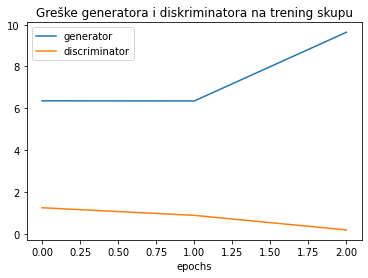

In [28]:
plt.plot(gen_losses, label="generator")
plt.plot(discr_losses, label="discriminator")
plt.xlabel("epochs")
plt.legend()
plt.title("Greške generatora i diskriminatora na trening skupu")
plt.show()

#### Rezultati kolorizacije nad validacionom skupu

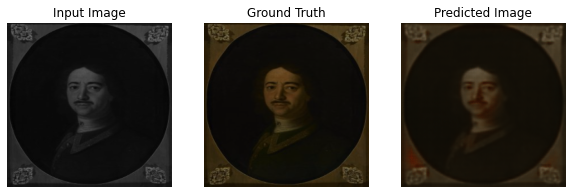

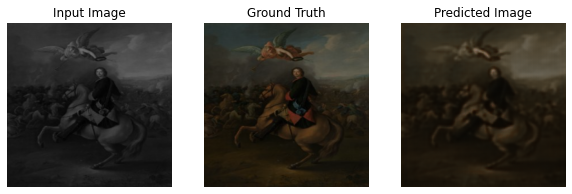

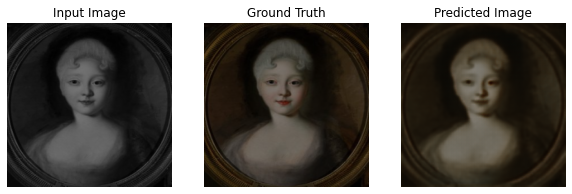

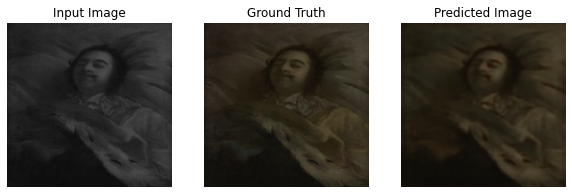

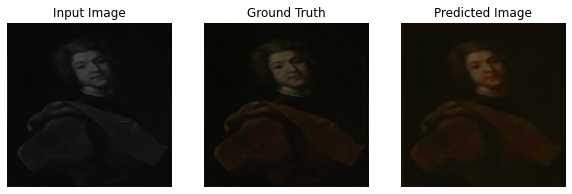

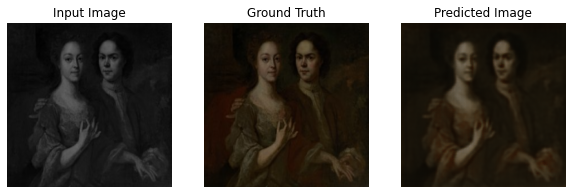

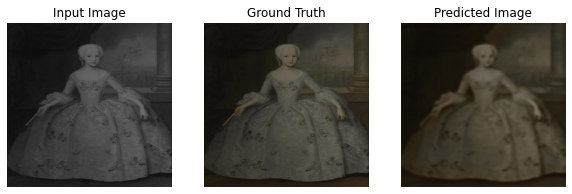

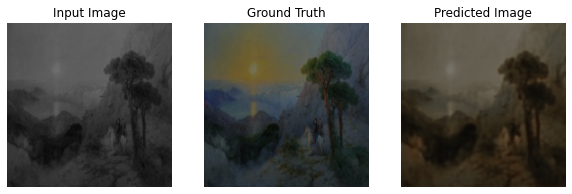

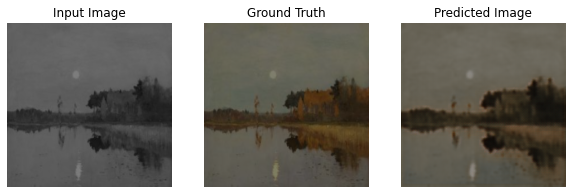

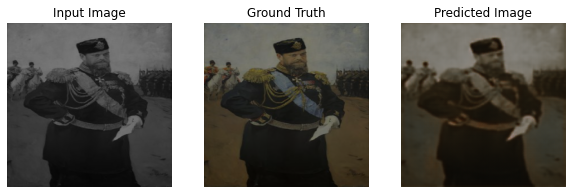

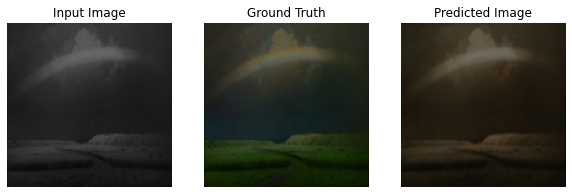

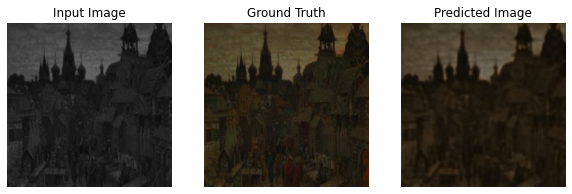

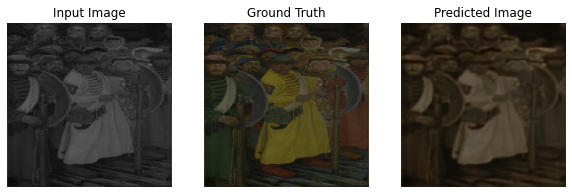

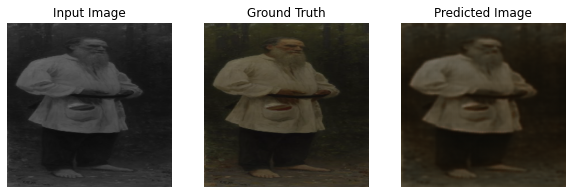

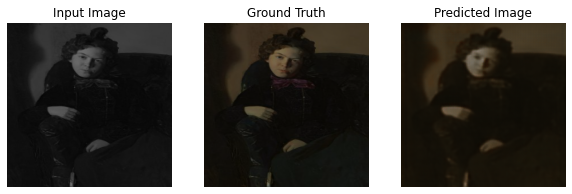

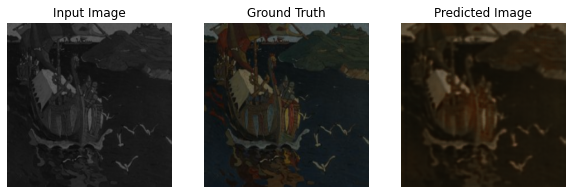

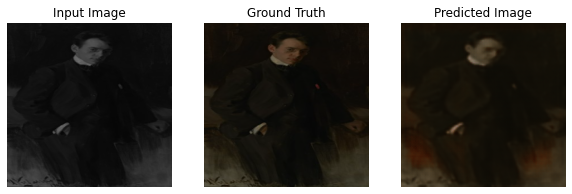

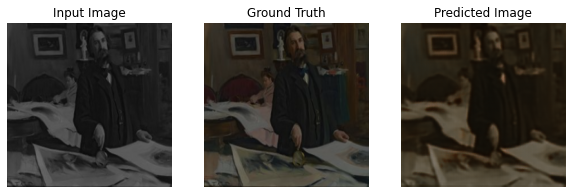

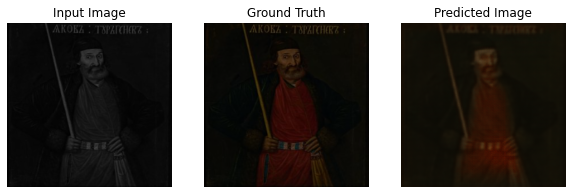

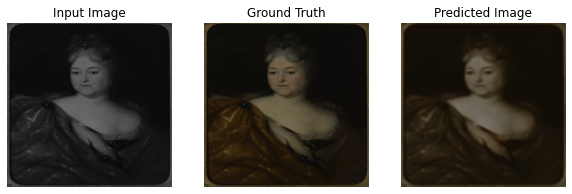

In [39]:
imgi = 2
for inp, tar in val_dataset.take(20):
    generate_images(generator, inp, tar, save_filename=False, display_imgs=True)

In [51]:
# generator.save('model/colorizer')

#### Ponašanje modela na neviđenom skupu 

In [3]:
import os

path_test = "data/test/"
path_test_bw = "data/test_bw/"


In [4]:
def load_test_image(filename):
    input_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(path_test_bw + filename)), tf.float32)[..., :3]
    tar_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(path_test + filename)), tf.float32)[..., :3]
    input_img, tar_img = resize(input_img, tar_img, img_size)
  
    input_img, tar_img = normalize(input_img, tar_img)
    return input_img, tar_img

In [5]:
n = len(os.listdir(path_test))
print(n)

228


In [11]:
#test_dataset = tf.data.Dataset.from_tensor_slices(os.listdir(path_test))
#test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#test_dataset = test_dataset.batch(1)

In [12]:
#imgi = 2
#for inp, tar in test_dataset.take(20):
#    generate_images(generator, inp, tar, save_filename=False, display_imgs=True)